# Desafío Científico de Datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from IPython.display import display, Math, Latex
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from math import log, floor
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
from IPython.display import display
import os
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:
file_dataset = "../movies_data/movies.csv"
data = pd.read_csv(file_dataset, encoding = "ISO-8859-1")
seed = 2021
np.random.seed(seed)
BOLD = '\033[1m'
END_BOLD = '\033[0m'

### Variables de segmentación

In [3]:
binding_by_quantiles = True #Si está a false, se segmentarán las variables de presupuestos, beneficios e ingresos
                            #con el intervalo que se indique en las siguientes variables
k_binding_profits = 25 #expresando en millones. Es decir, el resultado sería: [25M-50M],[50M-75M]...
k_binding_gross = 25
k_binding_budget = 25

format_quantile = True #En caso de mantener la variable binding_by_quantiles a True,
                       #se puede elegir entre el formato en percentiles: [0.0,.20],[0.20,0.40]...
                       #o el formato con los valores que corresponda
k_quantile = 0.20      #el valor de los intervalos entre cuantiles.

if k_quantile != 0.05 and k_quantile != 0.1 and k_quantile != 0.25 and k_quantile != 0.20:
    k_quantile = 0.20

# Funciones

In [4]:
def format_num (num):
    return f'{num:,}'

def mean_category (df, category_selected, category_to_calculate, name):
    means = []
    genres = np.unique(df[category_selected])
    for g in genres:
        mean = df[df[category_selected] == g][category_to_calculate].mean()
        mean = round(mean,2)
        #mean = format_num(round(mean,2))
        means.append(mean)
        
    list_of_tuples = list(zip(genres, means))

    name_column = "Mean_" + category_to_calculate
    dm = pd.DataFrame(list_of_tuples, columns = [category_selected, name_column]) 

    return dm

def std_category (df, category_selected, category_to_calculate, name):
    varncs = []
    genres = np.unique(df[category_selected])
    for g in genres:
        var = df[df[category_selected] == g][category_to_calculate].std()
        var = round(var,2)
        varncs.append(var)
        
    list_of_tuples = list(zip(genres, varncs))

    name_column = "std_" + category_to_calculate
    dm = pd.DataFrame(list_of_tuples, columns = [category_selected, name_column]) 

    return dm

def join_df_mean (dm_budget, dm_gross, dm_ben):
    dm = dm_budget.copy()
    dm["Mean_gross"] = dm_gross["Mean_gross"]
    dm["Mean_profits"] = dm_ben["Mean_profits"]
    return dm

def create_df_of_category (df, category, value):
    sub_df = df[df[category] == value].copy()
    return sub_df

def show_corr_data (df):
    corr_data_b = df.corr()
    display(corr_data_b)
    #plt.matshow(corr_data_b)
    plt.figure(figsize=(10,7))
    sns.heatmap(corr_data_b, annot=True)
    
def delete_budget_profits(df):
    df.drop(['budget'], axis=1, inplace=True)
    df.drop(['budget'], axis=0, inplace=True)
    df.drop(['profits'], axis=1, inplace=True)
    df.drop(['profits'], axis=0, inplace=True)
    return df
    
def show_corr_data_all (df):
    corr_data = df.corr()
    display(corr_data)
    #plt.matshow(corr_data_b)
    plt.figure(figsize=(10,7))
    sns.heatmap(corr_data, annot=True)

    
def human_format(number):
    if number == 0:
        return "0M"
    negative = False
    if number < 0:
        number = number * -1
        negative = True

    units = ['', 'K', 'M', 'G', 'T', 'P']
    k = 1000.0
    magnitude = int(floor(log(number, k)))
    if negative:
        return '-%.0f%s' % (number / k**magnitude, units[magnitude])
    else:
        return '%.0f%s' % (number / k**magnitude, units[magnitude])

def create_dummies(df, var_name):
     
    dummy_vars = pd.get_dummies(df[var_name], prefix = var_name)
    df.drop([var_name], axis = 1, inplace = True)
    df = pd.concat([df, dummy_vars], axis = 1)
    
    return df

def create_crosstab_prob(crosstab):
    new_crosstab = crosstab.astype('float').div(crosstab.sum(axis=1), axis = 0)
    return new_crosstab

def create_crosstab(df, category1, category2): 
    crosstab = pd.crosstab(df[category1], df[category2])
    crosstab_prob = create_crosstab_prob(crosstab)
    return crosstab, crosstab_prob

def select_option(option):
    if option == "Presupuesto":
        x=budget
    if option == "Ingresos":
        x=gross
    if option == "Beneficios":
        x=profits
    if option == "Metraje":
        x=runtime
    if option == "Votos":
        x=votes
    if option == "Puntuación IMDB":
        x=score
    return x

def evaluate_chi (chi):
    if (chi<0.05):
        print(BOLD+"El p-valor es inferior a 0.05 y, por tanto, rechazamos la hipótesis nula. Las dos variables analizadas no son independientes. Podemos afirmar que hay relación entre ellas."+END_BOLD)
    else:
        print(BOLD+"El p-valor es superior a 0.05 y, por tanto, no podemos rechazar la hipótesis nula. No se puede asegurar la dependencia entre las dos variables estudiadas."+END_BOLD)
        
def compare_med(df, category_calculate, category_select, value_category, max_or_min):
    df = create_df_of_category(df,category_select,value_category)
    max_ = df[category_calculate].quantile(1.0)
    min_ = df[category_calculate].quantile(0.0)/max_
    med = df[category_calculate].quantile(0.5)/max_
    max_ = max_/max_
    if(max_or_min=="min"):
        print(value_category + ": la diferencia entre la mediana y el mínimo es " + str(med - min_))
        return med - min_
    if(max_or_min=="max"):
        print(value_category + ": la diferencia entre la mediana y el máximo es " + str(med - min_))
        return med - min_
        
def compare_med_list(df, category_calculate, category, list_values, max_or_min):
    dict_ = {}
    for lv in list_values:
        result = compare_med(df, category_calculate, category, lv, max_or_min)
        dict_[lv] = result
    print(BOLD+"Lista ordenada:"+END_BOLD)
    sort_dict(dict_)
    
    
def get_key(val, dict_):
    for key, value in dict_.items():
         if val == value:
                return key

def sort_dict(dict_):
    val_list = list(dict_.values())
    val_list = sorted(val_list, reverse=True)
    for i in range(len(val_list)):
                   val = val_list[i]
                   print(get_key(val, dict_) + ": " + str(val))
                
def test_chi (cross):
    test_chi2 = chi2_contingency(cross)
    print(test_chi2[1])
    evaluate_chi(test_chi2[1])
    
def create_df_with_freq(category, name):
    dict_count = data[category].value_counts().to_dict()
    df = pd.DataFrame(dict_count.items(), columns=[category, 'num_movies'])
    
    print("Media de películas por " + name + ": " + str(df.num_movies.mean()))
    print("Percentil 75 de las películas por " + name + ": " + str(df.num_movies.quantile(0.75)))
    print("")
    return df

'''def addcol():
    for index, row in data.iterrows():
    if row['name'] == "Stand by Me":
        data.at[index,'new_column'] = "ok"'''



def create_df_with_restrictions(df_freq, df, category, limit, name):
    
    df_new = df.copy()   
    df_freq.drop(df_freq[df_freq.num_movies < limit].index, inplace=True)
    array_unique = np.unique(df_freq[category]).tolist()
    df_new = df_new[df_new[category].isin(array_unique)]
    print("Número de " + name + " que pasan el sesgo: " + str(len(array_unique)))
    print("Películas en total para ese sesgo con " + name + ": " + str(len(df_new)))
    print("")
    
    return df_new

### Funciones para segmentar (data binding)

In [5]:
def create_bins(minb, maxb, k):
    return np.arange(minb, maxb, k)

def format_bins (bins):
    bins_formatted = []
    for b in bins:
        bins_formatted.append(human_format(b))
    return bins_formatted

def create_labels (bins, limit):
    bins_formatted = format_bins(bins)
    names = []
    for i in range(len(bins_formatted)):
        if (bins[i]<limit):
            names.append("[" + bins_formatted[i] + "," + bins_formatted[i+1] +"]")
        
    return names

def data_binding_profits(k):
    k = k*1000000
    maxb = 700000000.0
    maxb = maxb+k
    bins = create_bins(-200000000.0, maxb, k)
    names = create_labels(bins, 700000000.0)
    
    return bins, names

def data_binding_gross(k):
    k = k*1000000
    maxb = 1000000000.0
    maxb = maxb+k
    bins = create_bins(0.0, maxb, k)
    names = create_labels(bins, 1000000000.0)
    
    return bins, names

def data_binding_budget(k):
    k = k*1000000
    maxb = 400000000.0
    maxb = maxb+k
    bins = create_bins(0.0, maxb, k)
    names = create_labels(bins, 400000000.0)
    
    return bins, names

def create_labels_quantiles(bins, limit):
    names = []
    for i in range(len(bins)):
        if (bins[i]<limit):
            num1 = format_num(round(bins[i],2))
            num2 = format_num(round(bins[i+1],2))
            names.append("[" + str(num1) + ", " + str(num2) +"]")
        
    return names

def data_binding_quantiles(df, k, category):
    array_to_binding = create_bins(0.0, 1.0+k, k)
    quantiles = []
    for i in array_to_binding:
        quantiles.append(df[category].quantile(i))
        
    if(format_quantile==False):
        names = create_labels_quantiles(quantiles, df[category].quantile(1.0))
    else:
        names = create_labels_quantiles(array_to_binding, 1.0)
    
    return quantiles, names

# Descripción del conjunto de datos
Este es un conjunto de datos que recoge información sobre el mundo del cine para poder analizarlo en profundidad. **Tipo de cuestiones a responder**:
* ¿En qué género debería enfocarse la industria?
* ¿Cómo de importante es producir una buena película (nota en IMDB) para obtener muchos ingresos?
* ¿Es mejor producir una película para todos los públicos o una dirigida sólo al público adulto?
* ¿Hay algún actor que garantice el éxito de la película? ¿Y director?

A continuación, se definen las **clases del conjunto de datos**:
* **Budget**: presupuesto de la película (algunas no lo tienen)
* **Company**: la compañía de la película
* **Country**: país de origen
* **Director**: director de la película
* **Genre**: género cinematográfico
* **Gross**: ingresos generados
* **Name**: título de la película
* **Rating**: restricción de edad
* **Released**: fecha de estreno
* **Runtime**: tiempo de metraje de la película
* **Score**: nota media de las votaciones de los usuarios de IMDB
* **Votes**: número de votos
* **Star**: actor o actriz principal
* **Writer**: guionista de la película
* **Year**: año de estreno

In [6]:
budget = "budget"
company = "company"
country = "country"
director = "director"
genre = "genre"
gross = "gross"
title = "name"
rating = "rating"
released = "realased"
runtime = "runtime"
score = "score"
star = "star"
votes = "votes"
writer = "writer"
year = "year"
profits = "profits"
cost_effectiveness = "ceff"
month = "month_release"
profits_binding = "profits_binding"
gross_binding = "gross_binding"
budget_binding = "budget_binding"

In [7]:
data.head(10)

def show_dataframe(Option, Items):
    if(Option == "Head"):
        display(data.head(Items))
        
    if(Option == "Tail"):
        display(data.tail(Items))
        
interact(show_dataframe, Option=["Head", "Tail"], Items=[5,10,50,100]);

interactive(children=(Dropdown(description='Option', options=('Head', 'Tail'), value='Head'), Dropdown(descrip…

### Dimensiones

In [8]:
def dim_data (df):
    print("Número de muestras: " + str(df.shape[0]))
    print("Número de clases: " + str(df.shape[1]))

dim_data(data)

Número de muestras: 6820
Número de clases: 15


In [9]:
classes = data.columns.values

In [10]:
def total_null_in_class (df, c):
    return pd.isnull(df[c]).values.ravel().sum()


def total_null (df, classes):
    null_found = False
    for c in classes:
        n_nulls = total_null_in_class(df, c)
        if (n_nulls != 0):
            print("Hay " + str(n_nulls) + " valores nulos en la clase " + c + ".")
            null_found = True
    if(null_found == False):
        print("No hay valores nulos en este conjunto de datos.")
        
total_null(data, classes)

No hay valores nulos en este conjunto de datos.


### El problema de los beneficios
Este conjunto de datos se ha obtenido del portal IMDB y, tal y como recogen allí, la variable "budget" (presupuesto) sólo incluye los costes de producción.

**A continuación, se creará una nueva columna, la resta de Budget y Gross: Profits.**

In [11]:
data[profits] = data[gross] - data[budget]

In [12]:
@interact(Muestra=False)
def g(Muestra):
    if(Muestra==True):
        display(data.head(5))
    else:
        print(" ")

interactive(children=(Checkbox(value=False, description='Muestra'), Output()), _dom_classes=('widget-interact'…

### Definición de la columna "month_release" para indicar el mes del estreno

In [13]:
data[month] = pd.DatetimeIndex(data['released']).month
data[month].replace({1: "January",
                     2: "February",
                     3: "March",
                     4: "April",
                     5: "May",
                     6: "June",
                     7: "July",
                     8: "August",
                     9: "September",
                     10: "October",
                     11: "November",
                     12: "December"}, inplace=True)

In [14]:
data["day_release"] = pd.DatetimeIndex(data['released']).day

In [15]:
@interact(Muestra=False)
def g(Muestra):
    if(Muestra==True):
        display(data.head(5))
    else:
        print(" ")

interactive(children=(Checkbox(value=False, description='Muestra'), Output()), _dom_classes=('widget-interact'…

### Ajuste de las clasificaciones por edad

In [16]:
ratings = np.unique(data[rating])
ratings

array(['B', 'B15', 'G', 'NC-17', 'NOT RATED', 'Not specified', 'PG',
       'PG-13', 'R', 'TV-14', 'TV-MA', 'TV-PG', 'UNRATED'], dtype=object)

Se observa en la lista anterior que no hay una regla para definir las clasificaciones. En Estados Unidos se propone:
* G: todos los públicos
* PG: mayores de 10 años o menores de 10 años acompañados
* PG-13: no recomendado para menores de 13 años
* R: no recomendado para menores de 17 años
* NC-17: prohibido para menores de 18 años
* NR: desconocido

**El conjunto de datos tiene más clasificaciones (algunas redundantes) y se ha decidido realizar algunos cambios:**
* 'NOT RATED', 'NOT SPECIFIED' Y 'UNRATED' pasarán a la clasificación NR.
* Se considerará la clasificación NC-17 como R.
* La clasificación B (no recomendada para menores de 12 años) pasará a ser P-13.
* La clasificación B15 (no recomendada para menores de 15 años) pasará a ser R (las películas con clasificación B15 en México suelen tener la clasificación R en Estados Unidos).
* La clasificación TV-MA es para adultos, es decir, se englobará dentro de R y NC-17.
* La clasificación TV-PG pasará a ser PG.
* La clasificación TV-14 es equivalente a B15 y pasará a R.

In [17]:
def replace_values (df, column, old_value, new_value):
    df[column] = np.where(df[column] == old_value, new_value, df[column])

replace_values(data, rating, 'NOT RATED', 'NR')
replace_values(data, rating, 'Not specified', 'NR')
replace_values(data, rating, 'UNRATED', 'NR')
replace_values(data, rating, 'NC-17', 'R')
replace_values(data, rating, 'B', 'PG-13')
replace_values(data, rating, 'B15', 'R')
replace_values(data, rating, 'TV-MA', 'R')
replace_values(data, rating, 'TV-MA', 'R')
replace_values(data, rating, 'TV-PG', 'PG')
replace_values(data, rating, 'TV-14', 'R')
ratings = np.unique(data[rating])
ratings

array(['G', 'NR', 'PG', 'PG-13', 'R'], dtype=object)

In [18]:
@interact(Muestra=False)
def g(Muestra):
    if(Muestra==True):
        display(data.head(5))
    else:
        print(" ")

interactive(children=(Checkbox(value=False, description='Muestra'), Output()), _dom_classes=('widget-interact'…

# Valores desconocidos en la clase Budget
En este apartado se creará un nuevo dataframe con todas las filas cuyo valor en la categoría Budget sea 0.0 borradas:

In [19]:
values_budget = data[budget].value_counts().to_dict()
print("Número de valores desconocidos en la clase Budget: " + str(values_budget[0.0]))

Número de valores desconocidos en la clase Budget: 2182


In [20]:
data.replace(0, np.nan, inplace=True)
total_null(data, classes)

Hay 2182 valores nulos en la clase budget.


In [21]:
data.dropna(axis=0, how="any", inplace=True)
total_null(data, classes)
dim_data(data)

No hay valores nulos en este conjunto de datos.
Número de muestras: 4638
Número de clases: 18


# Clasificación NR

In [22]:
data_NR = data.copy()
dm_budget = mean_category(data_NR, rating, budget, "presupuesto")
dm_gross = mean_category(data_NR, rating, gross, "ingresos")
dm_ben = mean_category(data_NR, rating, profits, "beneficios")

dm_rating = join_df_mean (dm_budget, dm_gross, dm_ben)
dm_rating

,rating,Mean_budget,Mean_gross,Mean_profits
0,G,55168000.00,85715180.17,30547180.17
1,NR,5243903.18,977109.37,-4266793.81
2,PG,48565963.58,66504308.76,17938345.18
3,PG-13,49090238.31,63195728.30,14105490.00
4,R,23566731.49,27742669.41,4175937.92


**Nota**: los valores de las películas con clasificación NR son muy bajos.

In [23]:
def show_corr_rating_NR(Rating):
    data_corr_rating = create_df_of_category(data_NR, rating, Rating)
    show_corr_data(data_corr_rating)
    
ratings = np.unique(data_NR[rating])
interact(show_corr_rating_NR, Rating=ratings);

interactive(children=(Dropdown(description='Rating', options=('G', 'NR', 'PG', 'PG-13', 'R'), value='G'), Outp…

**Nota**: los valores del coeficiente de Pearson varían mucho de la clasificación NR al resto de clasificaciones por edad.

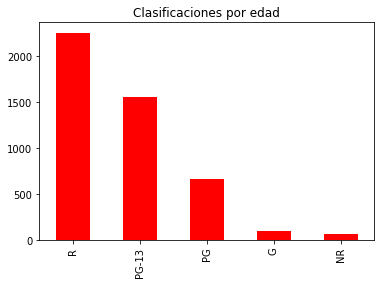

In [24]:
plot = data[rating].value_counts().plot(kind='bar', title='Clasificaciones por edad', color="r")

**Nota: Se ha decidido eliminar las películas con clasificación NR para que no empañen los resultados. Los datos de estas películas son muy diferentes al resto y, además, la muestra es muy pequeña.**

In [25]:
data.drop(data[data.rating == 'NR'].index, inplace=True)
ratings = np.unique(data[rating])
ratings

array(['G', 'PG', 'PG-13', 'R'], dtype=object)

In [26]:
encoder = OrdinalEncoder(categories=[["G", "PG", "PG-13", "R"]])

encoder.fit(data[[rating]])
data["rating_encoded"] = encoder.transform(data[[rating]])

# Inflación
El período que abarcan las películas es muy amplio, así que se han relativizado los valores del dólar en función del valor que tiene en 2021.

In [27]:
dict_infl={}
dict_infl["1986"]=2.38
dict_infl["1987"]=2.36
dict_infl["1988"]=2.26
dict_infl["1989"]=2.16
dict_infl["1990"]=2.07
dict_infl["1991"]=1.95
dict_infl["1992"]=1.89
dict_infl["1993"]=1.84
dict_infl["1994"]=1.79
dict_infl["1995"]=1.74
dict_infl["1996"]=1.7
dict_infl["1997"]=1.64
dict_infl["1998"]=1.61
dict_infl["1999"]=1.59
dict_infl["2000"]=1.55
dict_infl["2001"]=1.5
dict_infl["2002"]=1.47
dict_infl["2003"]=1.44
dict_infl["2004"]=1.41
dict_infl["2005"]=1.37
dict_infl["2006"]=1.32
dict_infl["2007"]=1.29
dict_infl["2008"]=1.24
dict_infl["2009"]=1.24
dict_infl["2010"]=1.21
dict_infl["2011"]=1.19
dict_infl["2012"]=1.15
dict_infl["2013"]=1.13
dict_infl["2014"]=1.12
dict_infl["2015"]=1.11
dict_infl["2016"]=1.1
years = np.unique(data[year])
data["infl"] = data["year"]
for y in years:
    data.loc[(data.year == y),'infl'] = dict_infl[str(y)]
    
data["budget"] = data["budget"] * data["infl"]
data["profits"] = data["profits"] * data["infl"]
data["gross"] = data["gross"] * data["infl"]
data.drop('infl', inplace=True, axis=1)

In [28]:
data.tail(5)

,budget,company,country,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year,profits,month_release,day_release,rating_encoded
6808,3300000.0,Westerly Films,Ireland,Whit Stillman,Comedy,15414920.4,Love & Friendship,PG,2016-06-03,90,6.5,Kate Beckinsale,17862,Whit Stillman,2016,12114920.4,June,3,1.0
6809,4180000.0,Sycamore Pictures,USA,John Krasinski,Comedy,1118559.2,The Hollars,PG-13,2016-08-26,88,6.5,Sharlto Copley,7227,Jim Strouse,2016,-3061440.8,August,26,2.0
6811,9350000.0,CBS Films,USA,Steve Carr,Animation,21983715.6,Middle School: The Worst Years of My Life,PG,2016-10-07,92,6.1,Griffin Gluck,4556,Chris Bowman,2016,12633715.6,October,7,1.0
6814,22000000.0,LD Entertainment,USA,Kevin Reynolds,Action,40562219.5,Risen,PG-13,2016-02-19,107,6.3,Joseph Fiennes,19084,Kevin Reynolds,2016,18562219.5,February,19,2.0
6817,3850000.0,Warner Bros. Animation,USA,Sam Liu,Animation,4152500.0,Batman: The Killing Joke,R,2016-07-25,76,6.5,Kevin Conroy,36333,Brian Azzarello,2016,302500.0,July,25,3.0


# Segmentación de los beneficios y los ingresos
* Las variables "k_binding_profits", "k_binding_gross" y "k_binding_budget" indican el tamaño de los intervalos entre los que se segmentarán.
* En caso de que la variable "binding_by_quantiles" sea True, se dividirá en percentiles según el valor de "k_quantile". Para segmentar de 5 en 5 percentiles, 0.05; para segmentar de 10 en 10 percentiles, 0.1, etc.

In [29]:
if(binding_by_quantiles==True):
    bins, names_biding_profits = data_binding_quantiles(data, k_quantile, profits)
    data[profits_binding] = pd.cut(data[profits], bins, labels=names_biding_profits)

    bins, names_biding_gross = data_binding_quantiles(data, k_quantile, gross)
    data[gross_binding] = pd.cut(data[gross], bins, labels=names_biding_gross)
    
    bins, names_biding_budget = data_binding_quantiles(data, k_quantile, budget)
    data[budget_binding] = pd.cut(data[budget], bins, labels=names_biding_budget)
    
else:
    bins, names_biding_profits = data_binding_profits(k_binding_profits)
    data[profits_binding] = pd.cut(data[profits], bins, labels=names_biding_profits)

    bins, names_biding_gross = data_binding_gross(k_binding_gross)
    data[gross_binding] = pd.cut(data[gross], bins, labels=names_biding_gross)
    
    bins, names_biding_budget = data_binding_budget(k_binding_budget)
    data[budget_binding] = pd.cut(data[budget], bins, labels=names_biding_budget)


In [30]:
@interact(Muestra=False)
def g(Muestra):
    if(Muestra==True):
        display(data.head(5))
    else:
        print(" ")

interactive(children=(Checkbox(value=False, description='Muestra'), Output()), _dom_classes=('widget-interact'…

In [31]:
data["success"] = 0

threshold = data["gross"].quantile(0.75)

for index, row in data.iterrows():
    if row["gross"] > threshold:
        data.at[index,'success'] = 1

# Scatter plots

In [32]:
%matplotlib inline
#savefig("path")

In [33]:
options = ["Presupuesto", "Ingresos", "Beneficios", "Puntuación IMDB", "Votos", "Metraje"]
def show_scatter_plots(Axis_x, Axis_y):
    x = select_option(Axis_x)
    y = select_option(Axis_y)
      
    data.plot(kind="scatter", x=x, y=y, xlabel = Axis_x, ylabel = Axis_y,
          title ="Scatter plot: " + Axis_x + " vs " + Axis_y, color = "c")
        
interact(show_scatter_plots, Axis_x=options, Axis_y=options);

interactive(children=(Dropdown(description='Axis_x', options=('Presupuesto', 'Ingresos', 'Beneficios', 'Puntua…

# Histogramas

In [34]:
def sturges(df):
    k = np.ceil(1+np.log2(len(df)))
    k = int(k)
    return k
k = sturges(data)

In [35]:
def show_hist(Category):
    column = select_option(Category)
       
    plt.hist(data[column], bins = k, color = "m")
    plt.xlabel(Category)
    plt.ylabel("Frecuencia")
    plt.title("Histograma de " + Category)
        
interact(show_hist, Category=options);

interactive(children=(Dropdown(description='Category', options=('Presupuesto', 'Ingresos', 'Beneficios', 'Punt…

# Boxplot

In [36]:
def interquartile_range (df, cl):
    gross25 = df[cl].describe()[4]
    gross75 = df[cl].describe()[6]
    return gross75 - gross25

def class_describe (df, cl):
    print(df[cl].describe())
    iqr = interquartile_range(df, cl)
    print("IQR: " + str(iqr))
    limit1 = df[cl].quantile(0.25) - 1.5*iqr
    limit2 = df[cl].quantile(0.75) + 1.5*iqr
    print("Límite bajo: " + str(limit1))
    print("Límite alto: " + str(limit2))

In [37]:
def show_boxplot(Category):
       
    column = select_option(Category)
       
    plt.boxplot(data[column])
    plt.ylabel(Category)
    plt.title("Boxplot de " + Category)
    class_describe(data, column)
        
interact(show_boxplot, Category=options);

interactive(children=(Dropdown(description='Category', options=('Presupuesto', 'Ingresos', 'Beneficios', 'Punt…

**Boxplot de los ingresos**: el 75% de los datos más bajos está muy concentrado y el 25% de los datos más altos está muy disperso. Los ingresos crecen desorbitadamente en algunas películas. La varianza hacia arriba es muy alta.

**Boxplot del presupuesto**: sucede algo similar, aunque el 75% de los presupuestos más bajos no está tan concentrado. La mediana está más alejada del mínimo y el IQR es más alto.

**Boxplot de los beneficios**: el rango intercuartílico es muy bajo. El 50% de los datos (25% por encima de la mediana y 25% por debajo de ella) está muy concentrado. Además, a diferencia de lo que sucedía en los gráficos anteriores, aquí también hay muchas excepciones que se escapan por debajo del cuartil 25, aunque la varianza es más alta hacia abajo que hacia arriba.

**Boxplot de las puntuaciones**: aquí vemos una representación más normalizada, aunque con muchos outliers de baja puntuación. No sucede lo mismo con las notas altas. La varianza es muy alta hacia abajo.

**Boxplot del número de votos**: es muy parecido al boxplot de los ingresos, con la mediana muy cerca del mínimo, el IQR muy bajo y la varianza muy alta hacia arriba. Tendría sentido que estas dos variables estén correlacionadas. A más ingresos, más visionados, más votos de usuarios.

# Coeficiente de Correlación de Pearson

¿Hay correlación entre algunas categorías?

,budget,gross,runtime,score,votes,year,profits,day_release,rating_encoded,success
budget,1.000000,0.630694,0.337389,0.066138,0.428243,0.116724,0.081783,-0.006667,-0.287265,0.531296
gross,0.630694,1.000000,0.260678,0.243381,0.623233,0.031984,0.825012,-0.010883,-0.263803,0.747520
runtime,0.337389,0.260678,1.000000,0.417426,0.365277,0.043797,0.089096,0.005178,0.144002,0.206821
score,0.066138,0.243381,0.417426,1.000000,0.476331,0.059662,0.264410,-0.010634,0.121920,0.208188
votes,0.428243,0.623233,0.365277,0.476331,1.000000,0.186702,0.488561,-0.012773,-0.004210,0.466473
year,0.116724,0.031984,0.043797,0.059662,0.186702,1.000000,-0.043923,0.019659,-0.017347,0.004548
profits,0.081783,0.825012,0.089096,0.264410,0.488561,-0.043923,1.000000,-0.009122,-0.129610,0.573137
day_release,-0.006667,-0.010883,0.005178,-0.010634,-0.012773,0.019659,-0.009122,1.000000,-0.015618,-0.016278
rating_encoded,-0.287265,-0.263803,0.144002,0.121920,-0.004210,-0.017347,-0.129610,-0.015618,1.000000,-0.236458
success,0.531296,0.747520,0.206821,0.208188,0.466473,0.004548,0.573137,-0.016278,-0.236458,1.000000


<AxesSubplot:>

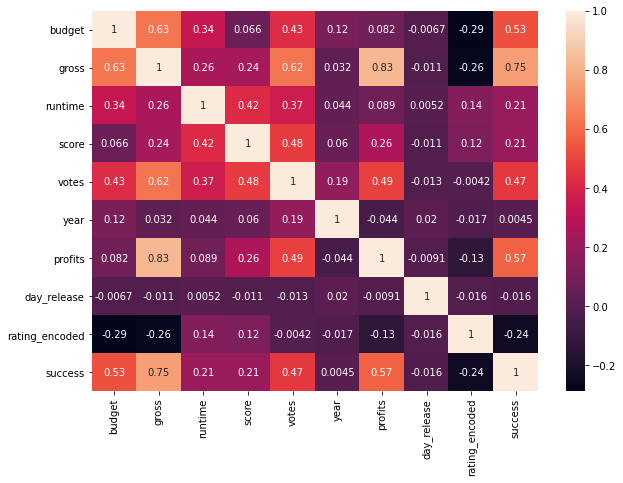

In [38]:
corr_data = data.corr()
display(corr_data)
plt.figure(figsize=(10,7))
sns.heatmap(corr_data, annot=True)

Tras calcular el Coeficiente de Pearson, se ha observado cierta correlación (que puede no implicar causalidad) entre algunas categorías:
* **Ingresos y presupuesto (0.64)**: ¿a mayor presupuesto, mayor recaudación? Hay dependencia.
* **Votos e ingresos (0.63)**: tal y como se predijo en los boxplots, parece que hay cierta depende entre estas dos variables.
* **Votos y presupuesto (0.44)**: ¿a mayor presupuesto, mayor número de votos? Es un coeficiente bajo, aunque hay cierta dependencia.
* **Beneficios e ingresos (0.83)**: cuanto mayores sean los ingresos, mayores serán los beneficios. Es lógico que estas dos variables estén correlacionadas, aunque no hay que olvidar que no se incluye los gatos de posproducción.
* **Beneficios y votos (0.49)**: cuanto mayor sea el número de votos, mayores serán también los beneficios, igual que sucedía con los ingresos, aunque no se trata de un coeficiente muy alto.

Entonces, **¿cómo de importante es producir una buena película (basándose en la nota en IMDB) para obtener muchos ingresos?** Poco importante. El coeficiente de correlación es de 0.25, muy bajo. La dependencia es mínima.
**¿Y para conseguir muchos votos?** Hay más correlación, un 0.48 pero no es determinante, sigue siendo bajo.

Text(0, 0.5, 'Ingresos')

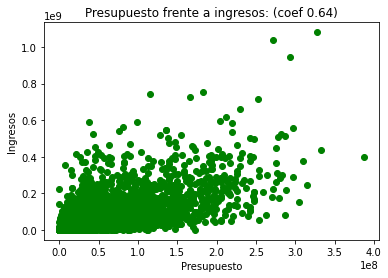

In [39]:
plt.plot(data.budget, data.gross, "go")
plt.title("Presupuesto frente a ingresos: (coef 0.64)")
plt.xlabel("Presupuesto")
plt.ylabel("Ingresos")

Text(0, 0.5, 'Ingresos')

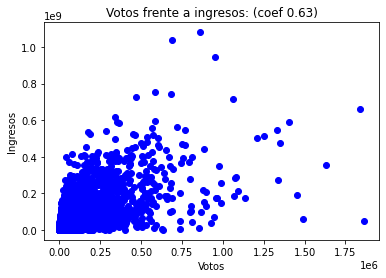

In [40]:
plt.plot(data.votes, data.gross, "bo")
plt.title("Votos frente a ingresos: (coef 0.63)")
plt.xlabel("Votos")
plt.ylabel("Ingresos")

Text(0, 0.5, 'Presupuesto')

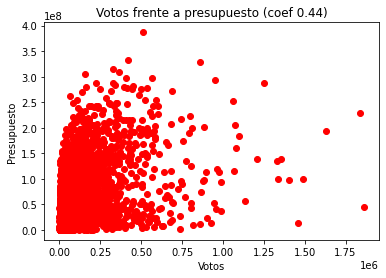

In [41]:
plt.plot(data.votes, data.budget, "ro")
plt.title("Votos frente a presupuesto (coef 0.44)")
plt.xlabel("Votos")
plt.ylabel("Presupuesto")

Text(0, 0.5, 'Ingresos')

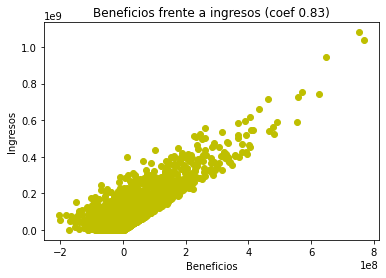

In [42]:
plt.plot(data.profits, data.gross, "yo")
plt.title("Beneficios frente a ingresos (coef 0.83)")
plt.xlabel("Beneficios")
plt.ylabel("Ingresos")

Text(0, 0.5, 'Beneficios')

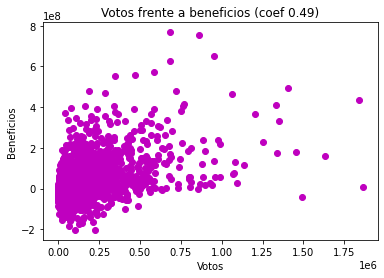

In [43]:
plt.plot(data.votes, data.profits, "mo")
plt.title("Votos frente a beneficios (coef 0.49)")
plt.xlabel("Votos")
plt.ylabel("Beneficios")

Text(0, 0.5, 'Ingresos')

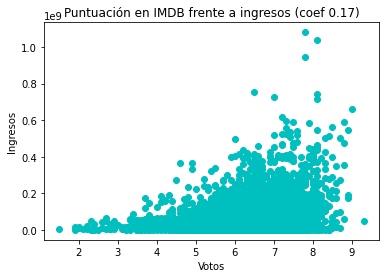

In [44]:
plt.plot(data.score, data.gross, "co")
plt.title("Puntuación en IMDB frente a ingresos (coef 0.17)")
plt.xlabel("Votos")
plt.ylabel("Ingresos")

# Análisis de las clasificaciones por edad


In [45]:
ratings = np.unique(data[rating])

## Beneficios, ingresos, presupuesto y clasificaciones
* Para los cálculos de las tablas de contingencia se utilizarán las variables segmentadas de beneficios, presupuesto e ingresos.

In [46]:
dm_budget = mean_category(data, rating, budget, "presupuesto")
dm_gross = mean_category(data, rating, gross, "ingresos")
dm_ben = mean_category(data, rating, profits, "beneficios")

dm_rating = join_df_mean (dm_budget, dm_gross, dm_ben)
dm_rating

,rating,Mean_budget,Mean_gross,Mean_profits
0,G,80111230.00,1.275469e+08,47435678.42
1,PG,67392267.53,9.463522e+07,27242954.35
2,PG-13,66673444.59,8.678222e+07,20108777.67
3,R,34838078.89,4.168825e+07,6850172.54


### Tabla de contingencia: beneficios
* Tabla de contingencia de los beneficios y la clasificación por edades.

In [47]:
cont_table_profits_rating, cont_table_profits_rating_p = create_crosstab(data, rating, profits_binding)

def show_crosstab_tables(Tabla):
    if(Tabla == "Tabla de contingencia"):
        print(BOLD+"Tabla de contingencia:"+END_BOLD)
        display(cont_table_profits_rating)
    
    if(Tabla == "Películas por clasificación"):
        print(BOLD+"\nPelículas por clasificación:"+END_BOLD)
        print(cont_table_profits_rating.sum(axis=1))
    
    if(Tabla == "Películas por intervalo"):
        print(BOLD+"\nPelículas por intervalo:"+END_BOLD)
        print(cont_table_profits_rating.sum(axis=0))
    
    if(Tabla == "Tabla de contingencia con probabilidades"):
        print(BOLD+"\nTabla de contingencia con probabilidades:"+END_BOLD)
        display(cont_table_profits_rating_p)
        
interact(show_crosstab_tables, Tabla=["Tabla de contingencia", "Películas por clasificación", 
                        "Películas por intervalo", "Tabla de contingencia con probabilidades"]);

interactive(children=(Dropdown(description='Tabla', options=('Tabla de contingencia', 'Películas por clasifica…

#### ¿Cuál es la probabilidad de que una película tenga unos benificios entre [profits_bining] si su clasificación es [rating]?

In [48]:
display(Math(r' P(Beneficios|Clasificación) = \frac{Nº\ total\ de\ películas\ con\ esa\ clasificación\ en\ ese\ rango}{Nº\ total\ de\ películas\ con\ esa\ clasificación} = \frac{Intervalo\ de\ beneficios\cap Clasficación\ X}{Clasificación\ X}'))


<IPython.core.display.Math object>

In [49]:
def show_prob_rating_profits(Rating, Interval):
    prob = cont_table_profits_rating_p[Interval][Rating]
    prob = round(prob,2)
    prob = prob*100
    print(BOLD+"\nProbability: "+str(prob)+"%"+END_BOLD)
    
ratings = np.unique(data[rating])
    
interact(show_prob_rating_profits, Rating=ratings, Interval=cont_table_profits_rating_p.columns.values.tolist());

interactive(children=(Dropdown(description='Rating', options=('G', 'PG', 'PG-13', 'R'), value='G'), Dropdown(d…

#### Test de la Chi-Cuadrado con la tabla de contingencia: ¿existe relación entre los beneficios y las clasificaciones?

In [50]:
test_chi2 = chi2_contingency(cont_table_profits_rating)
calculate_test = pd.DataFrame(test_chi2[3])
calculate_test_rel = round(calculate_test.apply(lambda r: r/len(data)*100, axis=1 ), 2)
table_rel = round(cont_table_profits_rating.apply(lambda r: r/len(data)*100, axis=1 ), 2)
print(test_chi2[1])
evaluate_chi(test_chi2[1])

5.312779558331595e-43
El p-valor es inferior a 0.05 y, por tanto, rechazamos la hipótesis nula. Las dos variables analizadas no son independientes. Podemos afirmar que hay relación entre ellas.


### Tabla de contingencia: ingresos
* Tabla de contingencia de los ingresos y la clasificación por edades

In [51]:
cont_table_gross_rating, cont_table_gross_rating_p = create_crosstab(data, rating, gross_binding)

def show_crosstab_tables_gross(Tabla):
    if(Tabla == "Tabla de contingencia"):
        print(BOLD+"Tabla de contingencia:"+END_BOLD)
        display(cont_table_gross_rating)
    
    if(Tabla == "Películas por clasificación"):
        print(BOLD+"\nPelículas por clasificación:"+END_BOLD)
        print(cont_table_gross_rating.sum(axis=1))
    
    if(Tabla == "Películas por intervalo"):
        print(BOLD+"\nPelículas por intervalo:"+END_BOLD)
        print(cont_table_gross_rating.sum(axis=0))
    
    if(Tabla == "Tabla de contingencia con probabilidades"):
        print(BOLD+"\nTabla de contingencia con probabilidades:"+END_BOLD)
        display(cont_table_gross_rating_p)
        
interact(show_crosstab_tables_gross, Tabla=["Tabla de contingencia", "Películas por clasificación", 
                        "Películas por intervalo", "Tabla de contingencia con probabilidades"]);

interactive(children=(Dropdown(description='Tabla', options=('Tabla de contingencia', 'Películas por clasifica…

#### ¿Cuál es la probabilidad de que una película tenga unos ingresos entre [gross_bining] si su clasificación es [rating]?

In [52]:
display(Math(r' P(Ingresos|Clasificación) = \frac{Nº\ total\ de\ películas\ con\ esa\ clasificación\ en\ ese\ rango}{Nº\ total\ de\ películas\ con\ esa\ clasificación} = \frac{Intervalo\ de\ ingresos\cap Clasficación\ X}{Clasificación\ X}'))


<IPython.core.display.Math object>

In [53]:
def show_prob_rating_gross(Rating, Interval):
    prob = cont_table_gross_rating_p[Interval][Rating]
    prob = round(prob,2)
    prob = prob*100
    print(BOLD+"\nProbability: "+str(prob)+"%"+END_BOLD)
    
ratings = np.unique(data[rating])


interact(show_prob_rating_gross, Rating=ratings, Interval=cont_table_gross_rating_p.columns.values.tolist());

interactive(children=(Dropdown(description='Rating', options=('G', 'PG', 'PG-13', 'R'), value='G'), Dropdown(d…

#### Test de la Chi-Cuadrado con la tabla de contingencia: ¿existe relación entre los ingresos y las clasificaciones?

In [54]:
test_chi(cont_table_gross_rating)

4.75570410925013e-100
El p-valor es inferior a 0.05 y, por tanto, rechazamos la hipótesis nula. Las dos variables analizadas no son independientes. Podemos afirmar que hay relación entre ellas.


### Tabla de contingencia: presupuestos

In [55]:
cont_table_budget_rating, cont_table_budget_rating_p = create_crosstab(data, rating, budget_binding)
test_chi(cont_table_budget_rating)

1.5068988156190547e-108
El p-valor es inferior a 0.05 y, por tanto, rechazamos la hipótesis nula. Las dos variables analizadas no son independientes. Podemos afirmar que hay relación entre ellas.


### Conclusiones: ingresos, beneficios, presupuesto y clasificaciones por edad
La clasificación por edades está correlacionada con los ingresos, el presupuesto y los beneficios, tal y como indican las pruebas de Chi Cuadrado.

### Coeficiente de Pearson en función de la clasificación por edades para los ingresos

In [56]:
def show_corr_rating(Rating):
    data_corr_rating = create_df_of_category(data, rating, Rating)
    show_corr_data(data_corr_rating)
    
ratings = np.unique(data[rating])

interact(show_corr_rating, Rating=ratings);

interactive(children=(Dropdown(description='Rating', options=('G', 'PG', 'PG-13', 'R'), value='G'), Output()),…

**En PG, G y R, la dependencia entre presupuesto e ingresos disminuye respecto al conjunto general. PG-13, en cambio, se acerca más a lo observado anteriormente. La correlación entre ingresos y puntuación (también entre beneficios y puntuación) aumenta ligeramente en G (respecto al resto de las clasificaciones y del plano general). De todas formas, la muestra de G es muy pequeña (sólo 100 películas) y los resultados no son absolutamente fiables.**

## ¿Qué clasificación por edades genera más ingresos?
Para responder a esta pregunta cogeremos el conjunto "data".

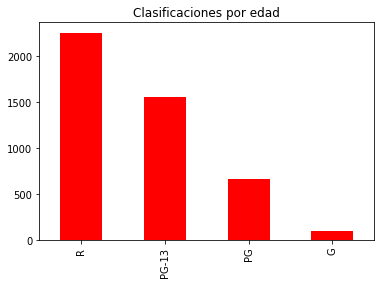

In [57]:
plot = data[rating].value_counts().plot(kind='bar', title='Clasificaciones por edad', color="r")

In [58]:
mean_gross_rating = mean_category(data, rating, gross, "ingresos")
display(mean_gross_rating.sort_values("Mean_gross", ascending=False))

std_gross_rating = std_category(data, rating, gross, "ingresos")
display(std_gross_rating.sort_values("std_gross", ascending=False))

,rating,Mean_gross
0,G,1.275469e+08
1,PG,9.463522e+07
2,PG-13,8.678222e+07
3,R,4.168825e+07


,rating,std_gross
0,G,1.262437e+08
2,PG-13,1.099348e+08
1,PG,1.025265e+08
3,R,5.662501e+07


In [59]:
def show_boxplot_rating(Category):
    sub_df = create_df_of_category (data, "rating", Category)
       
    plt.boxplot(sub_df[gross])
    plt.ylabel("Ingresos")
    plt.title("Boxplot de ingresos en " + Category)
    class_describe(sub_df, gross)
        
ratings = np.unique(data[rating])
interact(show_boxplot_rating, Category=ratings);

interactive(children=(Dropdown(description='Category', options=('G', 'PG', 'PG-13', 'R'), value='G'), Output()…

In [60]:
print(BOLD+"Cálculo (normalizado) de diferencias con la media:"+END_BOLD)
ratings = np.unique(data[rating])
compare_med_list(data, gross, rating, ratings, "min")

Cálculo (normalizado) de diferencias con la media:
G: la diferencia entre la mediana y el mínimo es 0.17197393116475718
PG: la diferencia entre la mediana y el mínimo es 0.07907818399787647
PG-13: la diferencia entre la mediana y el mínimo es 0.046730847618987555
R: la diferencia entre la mediana y el mínimo es 0.040623539387298416
Lista ordenada:
G: 0.17197393116475718
PG: 0.07907818399787647
PG-13: 0.046730847618987555
R: 0.040623539387298416


### Conclusiones
* **R**: es la clasificación con menos ingresos de media. Tiene una mediana y un IQR muy bajos. Apenas hay diferencia entre el 25% de los datos más bajos y los siguientes 50%. El 25% de los datos más altos está muy disperso, pero la mediana, el percentil 25 y el mínimo están muy cerca.
* **PG-13**: presenta el mismo inconveniente que la clasificación R, aunque la media de ingresos es mucho más alta y su varianza es la segunda más alta hacia arriba.
* **PG**: segunda media de ingresos más alta, tercera varianza más alta hacia arriba y segunda diferencia más alta entre la mediana y el mínimo.
* **G**: tiene la media ingresos, la varianza hacia arriba y la diferencia entre mediana y mínimo más altas, pero la muestra es muy pequeña respecto al resto de clasificaciones.

**¿Es mejor producir una película para todos los públicos o una dirigida sólo al público adulto?** Para todos los públicos (G) hay una muestra muy pequeña, aunque el análisis para esa muestra es muy favorable. Entre PG, PG-13 y R, la de las restricción para menores de edad es la peor opción (menos ingresos, menos varianza hacia arriba y la mediana más cerca del mínimo).

## ¿Qué cambia si analizamos los presupuestos?


In [61]:
mean_budget_rating = mean_category(data, rating, budget, "presupuesto")
display(mean_budget_rating.sort_values("Mean_budget", ascending=False))

std_budget_rating = std_category(data, rating, budget, "presupuesto")
display(std_budget_rating.sort_values("std_budget", ascending=False))

,rating,Mean_budget
0,G,80111230.00
1,PG,67392267.53
2,PG-13,66673444.59
3,R,34838078.89


,rating,std_budget
0,G,61587460.72
2,PG-13,59856351.82
1,PG,56280902.19
3,R,35078929.48


In [62]:
def show_boxplot_rating_budget(Category):
    sub_df = create_df_of_category (data, "rating", Category)
       
    plt.boxplot(sub_df[budget])
    plt.ylabel("Ingresos")
    plt.title("Boxplot de ingresos en " + Category)
    class_describe(sub_df, budget)
        
ratings = np.unique(data[rating])
interact(show_boxplot_rating_budget, Category=ratings);

interactive(children=(Dropdown(description='Category', options=('G', 'PG', 'PG-13', 'R'), value='G'), Output()…

In [63]:
print(BOLD+"Cálculo (normalizado) de diferencias con la media:"+END_BOLD)
ratings = np.unique(data[rating])
compare_med_list(data, budget, rating, ratings, "max")

Cálculo (normalizado) de diferencias con la media:
G: la diferencia entre la mediana y el máximo es 0.1869628099173554
PG: la diferencia entre la mediana y el máximo es 0.15342657342657343
PG-13: la diferencia entre la mediana y el máximo es 0.11883754521963824
R: la diferencia entre la mediana y el máximo es 0.08260534722222222
Lista ordenada:
G: 0.1869628099173554
PG: 0.15342657342657343
PG-13: 0.11883754521963824
R: 0.08260534722222222


### Análisis
* **R**: su presupuesto medio es, más o menos, la mitad que el de PG-13 y PG, pero su recaudación también lo es.
* **PG-13**: la varianza hacia arriba (ahora algo negativo) es superior a la de PG, y la media es muy similar. Asimismo, la distancia entre el máximo y la mediana también es ligeramente superior que en PG.
* **PG**: a falta de una muestra más grande con películas con clasificación G, se posiciona como la mejor opción tras este análisis.

## ¿Y si analizamos los beneficios?

In [64]:
mean_profits_rating = mean_category(data, rating, profits, "beneficios")
display(mean_profits_rating.sort_values("Mean_profits", ascending=False))

std_profits_rating = std_category(data, rating, profits, "beneficios")
display(std_profits_rating.sort_values("std_profits", ascending=False))

,rating,Mean_profits
0,G,47435678.42
1,PG,27242954.35
2,PG-13,20108777.67
3,R,6850172.54


,rating,std_profits
0,G,1.026511e+08
2,PG-13,8.517531e+07
1,PG,8.363894e+07
3,R,4.884346e+07


In [65]:
def show_boxplot_rating_profits(Category):
    sub_df = create_df_of_category (data, "rating", Category)
       
    plt.boxplot(sub_df[profits])
    plt.ylabel("Ingresos")
    plt.title("Boxplot de beneficios en " + Category)
    class_describe(sub_df, profits)
        
ratings = np.unique(data[rating])
interact(show_boxplot_rating_profits, Category=ratings);

interactive(children=(Dropdown(description='Category', options=('G', 'PG', 'PG-13', 'R'), value='G'), Output()…

### Conclusiones
* **R**: presenta mucha varianza hacia arriba y hacia abajo. No es la más recomendable. Es, además, la que menos beneficios genera.
* **PG-13 vs PG**: a falta de una mayor muestra con películas de clasificación G, la disputa queda entre PG-13 y PG. PG-13 tiene menores beneficios y una mayor varianza por abajo, mientras PG tiene más beneficios y más ingresos, además de una varianza muy poco pronunciada por abajo y una muy pronunciada por arriba en los beneficios.

# Análisis en cuanto al género

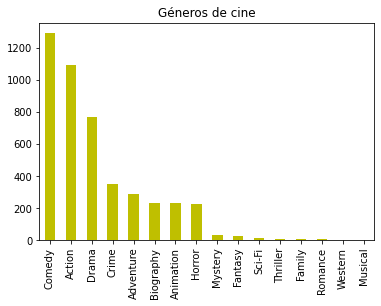

In [66]:
plot = data[genre].value_counts().plot(kind='bar', title='Géneros de cine', color="y")

In [67]:
dm_budget = mean_category(data, genre, budget, "presupuesto")
dm_gross = mean_category(data, genre, gross, "ingresos")
dm_ben = mean_category(data, genre, profits, "beneficios")

dm_genre = join_df_mean (dm_budget, dm_gross, dm_ben)

### Tabla de contingencia: ingresos
* Tabla de contingencia de los ingresos y la clasificación por edades

In [68]:
cont_table_gross_genre, cont_table_gross_genre_p = create_crosstab(data, genre, gross_binding)

def show_crosstab_tables_gross_genre(Tabla):
    if(Tabla == "Tabla de contingencia"):
        print(BOLD+"Tabla de contingencia:"+END_BOLD)
        display(cont_table_gross_genre)
    
    if(Tabla == "Películas por clasificación"):
        print(BOLD+"\nPelículas por clasificación:"+END_BOLD)
        print(cont_table_gross_genre.sum(axis=1))
    
    if(Tabla == "Películas por intervalo"):
        print(BOLD+"\nPelículas por intervalo:"+END_BOLD)
        print(cont_table_gross_genre.sum(axis=0))
    
    if(Tabla == "Tabla de contingencia con probabilidades"):
        print(BOLD+"\nTabla de contingencia con probabilidades:"+END_BOLD)
        display(cont_table_gross_genre_p)
        
interact(show_crosstab_tables_gross_genre, Tabla=["Tabla de contingencia", "Películas por género", 
                        "Películas por intervalo", "Tabla de contingencia con probabilidades"]);

interactive(children=(Dropdown(description='Tabla', options=('Tabla de contingencia', 'Películas por género', …

#### ¿Cuál es la probabilidad de que una película tenga unos ingresos entre [gross_bining] si su clasificación es [rating]?

In [69]:
def show_prob_genre_gross(Genre, Interval):
    prob = cont_table_gross_genre_p[Interval][Genre]
    prob = round(prob,2)
    prob = prob*100
    print(BOLD+"\nProbability: "+str(prob)+"%"+END_BOLD)
    
genres = np.unique(data[genre]) 
interact(show_prob_genre_gross, Genre=genres, Interval=cont_table_gross_genre_p.columns.values.tolist());

interactive(children=(Dropdown(description='Genre', options=('Action', 'Adventure', 'Animation', 'Biography', …

In [70]:
test_chi(cont_table_gross_genre)

5.261431320962941e-76
El p-valor es inferior a 0.05 y, por tanto, rechazamos la hipótesis nula. Las dos variables analizadas no son independientes. Podemos afirmar que hay relación entre ellas.


### Prueba chi cuadrado: presupuesto

In [71]:
cont_table_budget_genre, cont_table_budget_genre_p = create_crosstab(data, genre, budget_binding)
test_chi(cont_table_budget_genre)

5.0091344961153675e-171
El p-valor es inferior a 0.05 y, por tanto, rechazamos la hipótesis nula. Las dos variables analizadas no son independientes. Podemos afirmar que hay relación entre ellas.


### Prueba chi cuadrado: presupuesto

In [72]:
cont_table_profits_genre, cont_table_profits_genre_p = create_crosstab(data, genre, profits_binding)
test_chi(cont_table_profits_genre)

1.5843219175100775e-49
El p-valor es inferior a 0.05 y, por tanto, rechazamos la hipótesis nula. Las dos variables analizadas no son independientes. Podemos afirmar que hay relación entre ellas.


### Conclusiones: ingresos, presupuesto, beneficios y géneros
La variable de los géneros está correlacionada con los ingresos, beneficios y presupuesto, tal y como se acaba de demostrar con los test Chi Cuadrado.

### Medias de ingresos, presupuesto y beneficios en función del género

In [73]:
def show_ascending_genres_by_mean(OrderBy):
    display(dm_genre.sort_values(OrderBy, ascending=False))
interact(show_ascending_genres_by_mean, OrderBy=['Mean_budget','Mean_gross', 'Mean_profits']);

interactive(children=(Dropdown(description='OrderBy', options=('Mean_budget', 'Mean_gross', 'Mean_profits'), v…

**Los géneros más caros de media son:**
* Género[Animation]: 101 940 600
* Género[Action]: 84 355 610
* Género[Adventure]: 71 629 110
* Género[Mystery]: 50 372 220
* Género[Family]: 37 035 170.0

**Los géneros que más ingresan de media son:**
* Género[Animation]: 145 774 000
* Género[Adventure]: 98 875 820
* Género[Action]: 97 376 480
* Género[Mystery]: 63 283 720
* Género[Comedy]: 54 795 660

**Los géneros con mayor beneficio o menor déficit de media son:**
* Género[Animation]: 43 833 391.92
* Género[Adventure]: 27 246 712.57
* Género[Horror]: 22 446 484.51
* Género[Comedy]: 18 822 295.28
* Género[Action]: 13 020 871.15
* Género[Mystery]: 12 911 499.24
* Género[Biography]: 10 224 750.07

**Los géneros y el Coeficiente de Pearson**

In [74]:
def show_corr_genre(Genre):
    data_corr_genre = create_df_of_category(data, genre, Genre)
    show_corr_data(data_corr_genre)
    
genres = np.unique(data[genre])

interact(show_corr_genre, Genre=genres);

interactive(children=(Dropdown(description='Genre', options=('Action', 'Adventure', 'Animation', 'Biography', …

**El género de terror tiene un coeficiente de 0.89 entre ingresos y benificios, sólo un 0.34 entre ingresos y presupuesto, y un -0.13 entre beneficios y presupuesto. Esto quizá se vea influido por el llamado cine de "Serie B" (de bajos costes y no muy buena calidad), muy frecuente en el género de terror y, también, muy de moda en décadas pasadas. ¿Podría ser que el cine de terror ahora no fuera tan barato?**

In [75]:
data_horror = create_df_of_category(data, genre, "Horror")

a = np.array([1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996])
data_horror_90 = data_horror[data_horror.year.isin(a)]

b = np.array([2010, 2011, 2012, 2013, 2014, 2015, 2016])
data_horror_10 = data_horror[data_horror.year.isin(b)]


In [76]:
values_genre = data_horror_90[genre].value_counts().to_dict()
print("Número de películas de terror entre 1986-1996:")
for key in values_genre:
    print(key, '->', values_genre[key])
    
values_genre = data_horror_10[genre].value_counts().to_dict()
print("Número de películas de terror entre 2010-2016:")
for key in values_genre:
    print(key, '->', values_genre[key])
    
print("Media del presupuesto entre 1986-1996: " + str(data_horror_90[budget].mean()))
print("Desviación típica del presupuesto entre 1986-1996: " + str(data_horror_90[budget].std()))
print("Media del presupuesto entre 2010-2011: " + str(data_horror_10[budget].mean()))
print("Desviación típica del presupuesto entre 2010-2011: " + str(data_horror_10[budget].std()))

Número de películas de terror entre 1986-1996:
Horror -> 54
Número de películas de terror entre 2010-2016:
Horror -> 64
Media del presupuesto entre 1986-1996: 16645351.851851853
Desviación típica del presupuesto entre 1986-1996: 15906277.607494928
Media del presupuesto entre 2010-2011: 12583390.625
Desviación típica del presupuesto entre 2010-2011: 13286958.743315846


In [77]:
def show_corr_horror(Option):
    if(Option == "1986-1996"):
        show_corr_data(data_horror_90)
    else:
        show_corr_data(data_horror_10)
    
interact(show_corr_horror, Option=["1986-1996", "2010-2011"]);

interactive(children=(Dropdown(description='Option', options=('1986-1996', '2010-2011'), value='1986-1996'), O…

**Tras este breve análisis, se observa que el presupuesto de las películas de terror en los 80 y 90 era incluso superior al de ahora.**

**Debido al gran número de géneros, a continuación se van a comparar los que mayores ingresos y beneficios tienen: animación, aventura, terror, comedia, acción, misterio y biografía/basado en hechos reales**.

In [78]:
def show_hist_by_genre(Genre, Category):
    
    df = create_df_of_category(data, "genre", Genre)
    k = sturges(df)
       
    column = select_option(Category)
       
    plt.hist(df[column], bins = k)
    plt.xlabel(Category)
    plt.ylabel("Frecuencia")
    plt.title(Genre + ": Histograma de " + Category)
    
genres = ["Animation", "Adventure", "Horror", "Comedy", "Action", "Mystery", "Biography"]
        
interact(show_hist_by_genre, Genre = genres, Category=["Ingresos", "Beneficios", "Presupuesto"]);

interactive(children=(Dropdown(description='Genre', options=('Animation', 'Adventure', 'Horror', 'Comedy', 'Ac…

In [79]:
def show_std_genre(Option):
    
    option = select_option(Option)

    std_genre = std_category(data, genre, option, Option)
    std_genre= std_genre.loc[std_genre['genre'].isin(genres)]

    display(std_genre.sort_values("std_" + option, ascending=False))
print("Desviaciones típicas:")
genres = ["Animation", "Adventure", "Horror", "Comedy", "Action", "Mystery", "Biography"]
interact(show_std_genre, Option=["Ingresos", "Beneficios", "Presupuesto"]);

Desviaciones típicas:


interactive(children=(Dropdown(description='Option', options=('Ingresos', 'Beneficios', 'Presupuesto'), value=…

In [80]:
def show_boxplot_genre(Category, Option):
    sub_df = create_df_of_category (data, "genre", Category)
    
    option = select_option(Option)
       
    plt.boxplot(sub_df[option])
    plt.ylabel(Option)
    plt.title("Boxplot de " + Option + " en " + Category)
    class_describe(sub_df, option)
    
genres = ["Animation", "Adventure", "Horror", "Comedy", "Action", "Mystery", "Biography"]
interact(show_boxplot_genre, Category=genres, Option=["Ingresos", "Beneficios", "Presupuesto"]);

interactive(children=(Dropdown(description='Category', options=('Animation', 'Adventure', 'Horror', 'Comedy', …

In [81]:
def show_meds_genre(Data, Distancia):
    option = select_option(Data)
    print(BOLD+"Cálculo (normalizado) de diferencias con la mediana:"+END_BOLD)
    compare_med_list(data, option, genre, genres, Distancia)

genres = ["Animation", "Adventure", "Horror", "Comedy", "Action", "Mystery", "Biography"]
interact(show_meds_genre, Data=["Ingresos", "Beneficios", "Presupuesto"], Distancia=["max", "min"]);

interactive(children=(Dropdown(description='Data', options=('Ingresos', 'Beneficios', 'Presupuesto'), value='I…

### Ingresos:
* **Animación (145 774 000 dólares):** el género que más ingresa, con mucha diferencia. Su varianza hacia arriba también es la más alta. Tiene un IQR muy elevado y su distancia entre la mediana y el mínimo es la mayor.
* **Aventura (98 875 820 dólares):** el segundo género que más ingresa, con la segunda varianza más alta hacia arriba, pero con un IQR bajo y una distancia entre la mediana y el mínimo de las más reducidas.
* **Acción (97 376 480 dólares):** le sucede lo mismo que al género de aventura. A pesar de ser el tercero en media y varianza, tiene un IQR bajo y la segunda menor diferencia entre el mínimo y la mediana.
* **Misterio (63 283 720 dólares):** ingresa menos que los dos anteriores, pero su distancia con la mediana y el mínimo es mayor. Su IQR no es tan bajo.
* **Comedia (54 795 660 dólares):** también tiene un IQR bajo y la menor distancia entre el mínimo y la mediana. Muchos más outliers que el género de misterio.
* **Basado en hechos reales (46 00 0630 dólares):** tiene un IQR mayor y la distancia entre el mínimo y la mediana se aleja.
* **Terror (43 034 330 dólares):** tiene un IQR grande y la segunda mayor distancia entre el mínimo y la mediana, aunque sus ingresos sean, de media, los más bajos.

### Presupuesto:
* **Animación:** es el género más caro, con una varianza muy alta por arriba, aunque con pocos outliers. Su distancia entre la mediana y el máximo es la mayor de todas.

* **Acción:** el segundo género más caro, con la varianza más alta por arriba, con muchos outliers.

* **Aventura:** el tercer género más caro y la tercera varianza más alta por arriba. Se posiciona como mejor opción que el género de acción, pues ingresa más y su varianza hacia arriba respecto a los gastos es inferior.

* **Misterio:** es un género más barato, con menor varianza por arriba y menos outliers, pero la segunda diferencia más alta entre el máximo y la mediana.

* **Comedia:** presenta unos datos similares a los de misterio, aunque la diferencia entre el máximo y la mediana es la menor de todas.

* **Basado en hechos reales:** tiene una media de presupuesto de 35M, con una varianza baja por arriba y pocos outliers. Además, la distancia entre la mediana y el máximo es la tercer más alta.

* **Terror:** el género de terror es el más barato de todos, con 20M de media. Presenta la varianza más baja por arriba.

### Beneficios:
* **Acción:** no es de los que más beneficios produce y tiene una varianza pronunciada por abajo. Además, es muy caro. 

* **Aventura:** el género de aventura ingresa más y gasta menos. No tiene apenas varianza por abajo. Sin embargo, su IQR sí es bajo. Solo recomendable para presupuestos elevados.

* **Animación:** es el género más caro, pero también el que más beneficios genera, con la mayor varianza por arriba y mucha distancia entre el mínimo y la mediana. Es un género muy recomendabla para presupuestos elevados, mejor que aventura.

* **Terror:** el género más barato y el tercero que más beneficios produce. Tiene muchos outliers por arriba y, aunque su varianza sea baja, la diferencia entre el mínimo y la mediana es la tercera más alta. Es un género muy recomendable para presupuestos más bajos.

* **Comedia:** tiene un IQR muy bajo, con la varianza pronunciada también por abajo. No es muy recomendable.

* **Misterio:** no presenta muchas ganancias ni outliers. Una varianza apenas pronunciada, tanto por arriba como por abajo.
* **Basado en hechos reales:** la varianza es mayor, sobre todo por arriba. Se presenta como una mejor opción a misterio por su bajo coste.

# Análisis en cuanto al mes de estreno

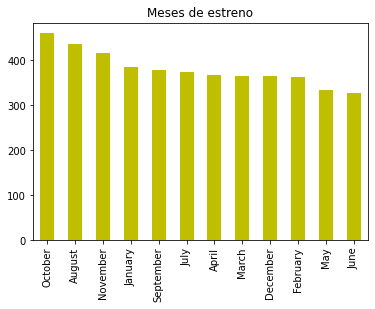

In [82]:
plot = data[month].value_counts().plot(kind='bar', title='Meses de estreno', color="y")

#### ¿Están relacionados los ingresos y el mes de estreno?

In [83]:
cont_table_gross_month, cont_table = create_crosstab(data, month, gross_binding)
test_chi(cont_table_gross_month)

8.872240838949593e-75
El p-valor es inferior a 0.05 y, por tanto, rechazamos la hipótesis nula. Las dos variables analizadas no son independientes. Podemos afirmar que hay relación entre ellas.


#### ¿Están relacionados el presupuesto y el mes de estreno?

In [84]:
cont_table_budget_month, cont_table = create_crosstab(data, month, budget_binding)
test_chi(cont_table_budget_month)

1.7655957916116426e-60
El p-valor es inferior a 0.05 y, por tanto, rechazamos la hipótesis nula. Las dos variables analizadas no son independientes. Podemos afirmar que hay relación entre ellas.


#### ¿Están relacionados los beneficios y el mes de estreno?

In [85]:
cont_table_profits_month, cont_table = create_crosstab(data, month, profits_binding)
test_chi(cont_table_profits_month)

3.526660690562893e-20
El p-valor es inferior a 0.05 y, por tanto, rechazamos la hipótesis nula. Las dos variables analizadas no son independientes. Podemos afirmar que hay relación entre ellas.


In [86]:
def show_stdmean_month(Data):
    
    option = select_option(Data)


    result = mean_category(data, month, option, Data)



    display(result.sort_values("Mean_" + option, ascending=False))
    
print("Desviaciones típicas:")
months = np.unique(data[month])
interact(show_stdmean_month, Data=["Ingresos", "Beneficios", "Presupuesto"])

Desviaciones típicas:


interactive(children=(Dropdown(description='Data', options=('Ingresos', 'Beneficios', 'Presupuesto'), value='I…

<function __main__.show_stdmean_month(Data)>

Vemos que apenas hay variación. Las películas que se estrenan en los meses de junio, mayo, diciembre, julio y noviembre son las que más ingresan, pero también las que mayor presupuesto tienen. Lo que se ha recomendado en anteriores apartados es:
* Clasificación por edades: PG
* Género: animación y aventura para altos presupuestos y terror y basado en hechos reales para bajos presupuestos.

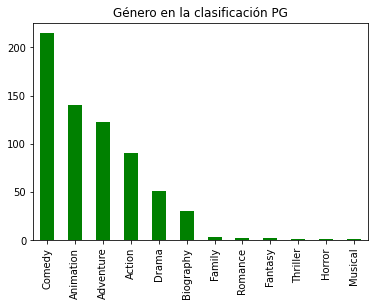

In [87]:
data_PG = create_df_of_category(data, rating, "PG")
plot = data_PG[genre].value_counts().plot(kind='bar', title='Género en la clasificación PG', color="g")

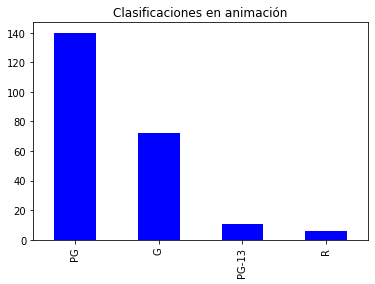

In [88]:
data_Animation = create_df_of_category(data, genre, "Animation")
plot = data_Animation[rating].value_counts().plot(kind='bar', title='Clasificaciones en animación', color="b")

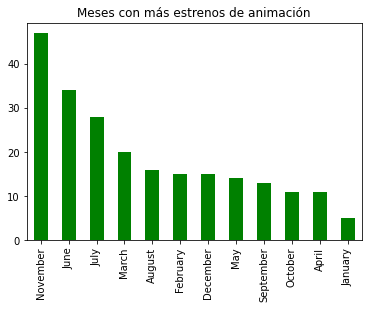

In [89]:
plot = data_Animation[month].value_counts().plot(kind='bar', title='Meses con más estrenos de animación', color="g")

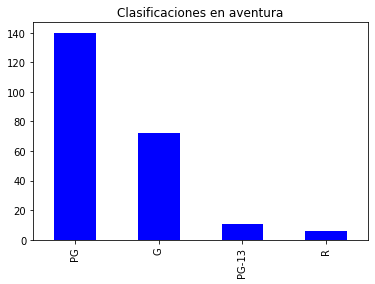

In [90]:
data_Adventure = create_df_of_category(data, genre, "Adventure")
plot = data_Animation[rating].value_counts().plot(kind='bar', title='Clasificaciones en aventura', color="b")

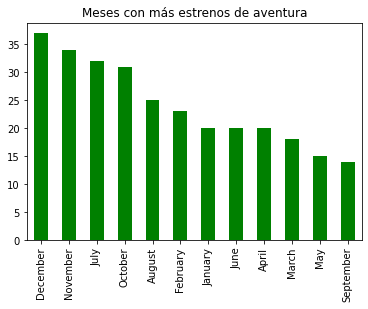

In [91]:
plot = data_Adventure[month].value_counts().plot(kind='bar', title='Meses con más estrenos de aventura', color="g")

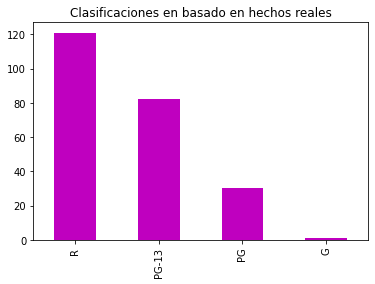

In [92]:
data_biography = create_df_of_category(data, genre, "Biography")
plot = data_biography[rating].value_counts().plot(kind='bar', title='Clasificaciones en basado en hechos reales', color="m")

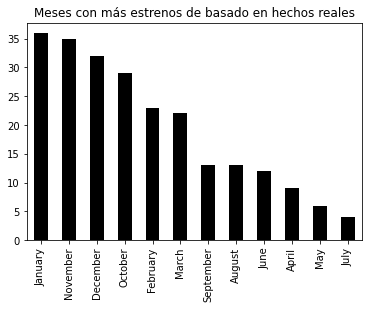

In [93]:
plot = data_biography[month].value_counts().plot(kind='bar', title='Meses con más estrenos de basado en hechos reales', color="k")

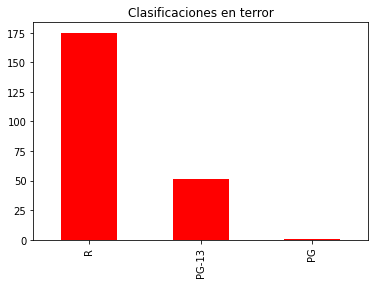

In [94]:
data_horror = create_df_of_category(data, genre, "Horror")
plot = data_horror[rating].value_counts().plot(kind='bar', title='Clasificaciones en terror', color="r")

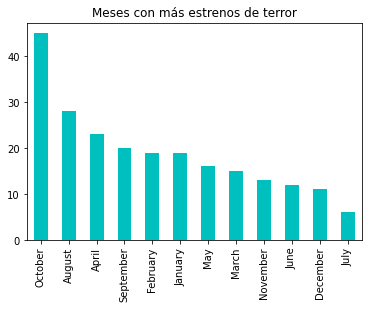

In [95]:
plot = data_horror[month].value_counts().plot(kind='bar', title='Meses con más estrenos de terror', color="c")

In [96]:

def show_boxplot_PG(Category, Option):
    sub_df = create_df_of_category (data, "genre", Category)
    
    option = select_option(Option)
       
    plt.boxplot(sub_df[option])
    plt.ylabel(Option)
    plt.title("Boxplot de " + Option + " en " + Category)
    class_describe(sub_df, option)
    
genres = ["Animation", "Adventure", "Horror", "Comedy", "Biography"]
interact(show_boxplot_PG, Category=genres, Option=["Ingresos", "Beneficios", "Presupuesto"]);

interactive(children=(Dropdown(description='Category', options=('Animation', 'Adventure', 'Horror', 'Comedy', …

In [97]:
limit_director = 3
limit_star = 3
limit_company = 10
limit_country = 2

data_directors = create_df_with_freq('director', 'director')
data_stars = create_df_with_freq('star', 'actor/actriz')
data_companies = create_df_with_freq('company', "compañía")
data_country = create_df_with_freq('country', "país")

d1 = create_df_with_restrictions(data_directors, data, director, limit_director, "directores")
d2 = create_df_with_restrictions(data_stars, d1, star, limit_star, "actores/actrices")
d3 = create_df_with_restrictions(data_companies, d2, company, limit_company, "compañías")
d4 = create_df_with_restrictions(data_country, d3, country, limit_country, "países")
data_b = d4

print("Películas en total: " + str(len(data_b)))

data_b = data_b.drop_duplicates()
print("Películas en total tras eliminar posibles duplicados: " + str(len(data_b)))

Media de películas por director: 2.46286329386437
Percentil 75 de las películas por director: 3.0

Media de películas por actor/actriz: 2.920229738353542
Percentil 75 de las películas por actor/actriz: 3.0

Media de películas por compañía: 3.5308641975308643
Percentil 75 de las películas por compañía: 2.0

Media de películas por país: 104.0
Percentil 75 de las películas por país: 12.25

Número de directores que pasan el sesgo: 536
Películas en total para ese sesgo con directores: 2927

Número de actores/actrices que pasan el sesgo: 432
Películas en total para ese sesgo con actores/actrices: 2293

Número de compañías que pasan el sesgo: 47
Películas en total para ese sesgo con compañías: 1560

Número de países que pasan el sesgo: 33
Películas en total para ese sesgo con países: 1560

Películas en total: 1560
Películas en total tras eliminar posibles duplicados: 1560


In [98]:
data_for_model = data.copy()
data_for_model.columns.values
data_for_model["gross_binding_cat"] = data_for_model["gross_binding"].cat.codes

In [99]:
X = data_for_model[["genre","profits"]]
Y = data_for_model["success"]
X = pd.get_dummies(X, columns=["genre"])

In [100]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state=seed)
lm = LogisticRegression(max_iter=10000)
lm.fit(X_train, Y_train)
prediction = lm.predict(X_test)

In [101]:
data_for_model = data_b.copy()
data_for_model.columns.values
data_for_model["gross_binding_cat"] = data_for_model["gross_binding"].cat.codes

In [102]:
X = data_for_model[["budget", "genre", "country", "director", "company", "star"]]
Y = data_for_model["gross_binding_cat"]
X = pd.get_dummies(X, columns=["genre", "country", "director", "company", "star"])
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state=seed)

In [103]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state=seed)
lm = LogisticRegression(max_iter=10000)
lm.fit(X_train, Y_train)
prediction = lm.predict(X_test)
metrics.accuracy_score(Y_test, prediction)

0.4017094017094017

In [104]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,Y_train)
Y_pred = clf.predict(X_test)
print("Accuracy Tree:",metrics.accuracy_score(Y_test, Y_pred))

Accuracy Tree: 0.3888888888888889


In [105]:
clf = DecisionTreeClassifier(criterion="entropy", max_depth=10)
clf = clf.fit(X_train,Y_train)
Y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred))

Accuracy: 0.3995726495726496


# Predicción de la variable presupuestos

In [106]:
data_for_model = data.copy()
data_for_model.columns.values
data_for_model["gross_binding_cat"] = data_for_model["gross_binding"].cat.codes

In [107]:
X = data_for_model[["gross", "runtime", "year", "genre", "rating", "country", "company"]]
Y = data_for_model["budget"]
X = pd.get_dummies(X, columns=["genre", "rating", "country", "company"])
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state=seed)

In [108]:
import sklearn.metrics as sm

X_train, X_test, Y_train, y_test = train_test_split(X,Y, test_size = 0.3, random_state=seed)
lm = LinearRegression()
lm.fit(X_train, Y_train)
prediction = lm.predict(X_test)
#lm.score(Y_test, prediction)
print("Mean absolute error =", round(sm.mean_absolute_error(y_test, prediction), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y_test, prediction), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y_test, prediction), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y_test, prediction), 2)) 
print("R2 score =", round(sm.r2_score(y_test, prediction), 2))

Mean absolute error = 25223448.06
Mean squared error = 1166809858634555.8
Median absolute error = 18658274.37
Explain variance score = 0.59
R2 score = 0.59


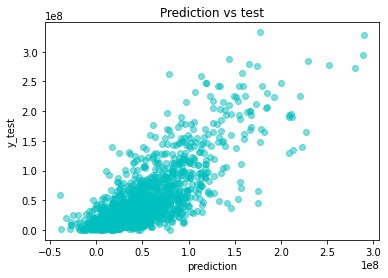

In [109]:
plt.scatter(prediction, y_test, c="c", alpha=0.5)
plt.title('Prediction vs test')
plt.xlabel('prediction')
plt.ylabel('y_test')
plt.show()

In [110]:
X = data_for_model[["gross", "runtime", "year", "genre", "rating"]]
Y = data_for_model["budget"]
X = pd.get_dummies(X, columns=["genre", "rating"])
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state=seed)

In [111]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
modelo = GradientBoostingRegressor(
            n_estimators = 10,
            loss         = 'ls',
            max_features = 'auto',
            random_state = 123
         )
modelo.fit(X_train, Y_train)

GradientBoostingRegressor(max_features='auto', n_estimators=10,
                          random_state=123)

In [112]:
predicciones = modelo.predict(X = X_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")
from sklearn.metrics import r2_score

r_squared = r2_score(y_test, predicciones)


El error (rmse) de test es: 39284679.13768241


In [113]:
r_squared

0.455959451099198

Se ha intenado predecir la variable presupuestos, pero el R2 no ha dado una buena medida.

# Directores, actores y compañías

In [114]:

limit_director = 3
limit_star = 3
limit_company = 20
limit_country = 20

data_directors = create_df_with_freq('director', 'director')
data_stars = create_df_with_freq('star', 'actor/actriz')
data_companies = create_df_with_freq('company', "compañía")
data_country = create_df_with_freq('country', "país")

d1 = create_df_with_restrictions(data_directors, data, director, limit_director, "directores")
d2 = create_df_with_restrictions(data_stars, data, star, limit_star, "actores/actrices")
d3 = create_df_with_restrictions(data_companies, data, company, limit_company, "compañías")
d4 = create_df_with_restrictions(data_country, data, country, limit_country, "países")

#data_b = d4

#print("Películas en total: " + str(len(data_b)))

#data_b = data_b.drop_duplicates()
#print("Películas en total tras eliminar posibles duplicados: " + str(len(data_b)))

Media de películas por director: 2.46286329386437
Percentil 75 de las películas por director: 3.0

Media de películas por actor/actriz: 2.920229738353542
Percentil 75 de las películas por actor/actriz: 3.0

Media de películas por compañía: 3.5308641975308643
Percentil 75 de las películas por compañía: 2.0

Media de películas por país: 104.0
Percentil 75 de las películas por país: 12.25

Número de directores que pasan el sesgo: 536
Películas en total para ese sesgo con directores: 2927

Número de actores/actrices que pasan el sesgo: 432
Películas en total para ese sesgo con actores/actrices: 3227

Número de compañías que pasan el sesgo: 31
Películas en total para ese sesgo con compañías: 2371

Número de países que pasan el sesgo: 8
Películas en total para ese sesgo con países: 4413



### Directores, compañías, países y actores con más películas

In [115]:
def show_datasets(Category):
    if(Category == "Directores"):
          display(data_directors.head(10))
    if(Category == "Actores/Actrices"):
           display(data_stars.head(10))
    if(Category == "Países"):
        display(data_country.head(10))
    if(Category == "Compañías"):
        display(data_companies.head(10))
        
interact(show_datasets, Category=["Directores", "Actores/Actrices", 
                        "Países", "Compañías"]);

interactive(children=(Dropdown(description='Category', options=('Directores', 'Actores/Actrices', 'Países', 'C…

In [116]:
def create_df_with_restrictions2(df_freq, df, category, limit, name):
    
    df_new = df.copy()   
    df_freq.drop(df_freq[df_freq.mean_gross < limit].index, inplace=True)
    array_unique = np.unique(df_freq[category]).tolist()
    df_new = df_new[df_new[category].isin(array_unique)]
    print("Número de " + name + " que pasan el sesgo: " + str(len(array_unique)))
    print("Películas en total para ese sesgo con " + name + ": " + str(len(df_new)))
    print("")
    return df_new

In [117]:
data_directors["mean_gross"] = 0.0

for index, row in data_directors.iterrows():
    name_director = row["director"]  
    data_directors.at[index,'mean_gross'] = data.loc[data['director'] == name_director, 'gross'].sum()
    
data_directors["mean_gross"] = data_directors["mean_gross"]/data_directors["num_movies"]



In [118]:
limit = data_directors["mean_gross"].quantile(0.5)

In [119]:
subset_directors = create_df_with_restrictions2(data_directors, data, director, limit, "directores")

Número de directores que pasan el sesgo: 268
Películas en total para ese sesgo con directores: 1668



In [120]:
per_direct = round(len(np.unique(subset_directors[director])) *100/len(np.unique(data[director])),2)
per_movies = round(len(subset_directors)*100/len(data),2)

In [121]:
print("El " + str(per_direct) + "% de los directores dirige el " 
      +str(per_movies) + "% de las películas.")

El 14.42% de los directores dirige el 36.45% de las películas.


In [122]:
data_stars["mean_gross"] = 0.0

for index, row in data_stars.iterrows():
    name_star = row["star"]  
    data_stars.at[index,'mean_gross'] = data.loc[data['star'] == name_star, 'gross'].sum()
    
data_stars["mean_gross"] = data_stars["mean_gross"]/data_stars["num_movies"]
limit = data_stars["mean_gross"].quantile(0.5)
subset_stars = create_df_with_restrictions2(data_stars, data, star, limit, "actores/actrices")

Número de actores/actrices que pasan el sesgo: 216
Películas en total para ese sesgo con actores/actrices: 2016



In [123]:
per_direct = round(len(np.unique(subset_stars[star])) *100/len(np.unique(data[star])),2)
per_movies = round(len(subset_stars)*100/len(data),2)
print("El " + str(per_direct) + "% de los actores/actrices protagoniza el " 
      +str(per_movies) + "% de las películas.")

El 13.78% de los actores/actrices protagoniza el 44.06% de las películas.


In [124]:
data_companies["mean_gross"] = 0.0

for index, row in data_companies.iterrows():
    name_companies = row["company"]  
    data_companies.at[index,'mean_gross'] = data.loc[data['company'] == name_companies, 'gross'].sum()
    
data_companies["mean_gross"] = data_companies["mean_gross"]/data_companies["num_movies"]
limit = data_companies["mean_gross"].quantile(0.5)
subset_companies = create_df_with_restrictions2(data_companies, data, company, limit, "compañías")

per_direct = round(len(np.unique(subset_companies[company])) *100/len(np.unique(data[company])),2)
per_movies = round(len(subset_companies)*100/len(data),2)
print("El " + str(per_direct) + "% de las compañías produce el " 
      +str(per_movies) + "% de las películas.")

Número de compañías que pasan el sesgo: 16
Películas en total para ese sesgo con compañías: 1804

El 1.23% de las compañías produce el 39.42% de las películas.


In [125]:
data_country["mean_gross"] = 0.0

for index, row in data_country.iterrows():
    name_companies = row["country"]  
    data_country.at[index,'mean_gross'] = data.loc[data['country'] == name_companies, 'gross'].sum()
    
data_country["mean_gross"] = data_country["mean_gross"]/data_country["num_movies"]
limit = data_country["mean_gross"].quantile(0.5)
subset_country = create_df_with_restrictions2(data_country, data, country, limit, "países")

per_direct = round(len(np.unique(subset_country[country])) *100/len(np.unique(data[country])),2)
per_movies = round(len(subset_country)*100/len(data),2)
print("El " + str(per_direct) + "% de los países produce el " 
      +str(per_movies) + "% de las películas.")

Número de países que pasan el sesgo: 4
Películas en total para ese sesgo con países: 4121

El 9.09% de los países produce el 90.06% de las películas.


In [126]:
len(np.unique(subset_directors[director]))

268

In [127]:
bins, names_biding_profits = data_binding_quantiles(subset_directors, k_quantile, profits)
subset_directors[profits_binding] = pd.cut(subset_directors[profits], bins, labels=names_biding_profits)

bins, names_biding_gross = data_binding_quantiles(subset_directors, k_quantile, gross)
subset_directors[gross_binding] = pd.cut(subset_directors[gross], bins, labels=names_biding_gross)

bins, names_biding_budget = data_binding_quantiles(subset_directors, k_quantile, budget)
subset_directors[budget_binding] = pd.cut(subset_directors[budget], bins, labels=names_biding_budget)

cont_table_gross_directors, cont_table_gross_directors_p = create_crosstab(subset_directors, director, gross_binding)
test_chi(cont_table_gross_directors)

0.0015081905849246653
El p-valor es inferior a 0.05 y, por tanto, rechazamos la hipótesis nula. Las dos variables analizadas no son independientes. Podemos afirmar que hay relación entre ellas.


In [128]:

def show_crosstab_tables_directors(Tabla):
    if(Tabla == "Tabla de contingencia"):
        print(BOLD+"Tabla de contingencia:"+END_BOLD)
        display(cont_table_gross_directors)
    
    if(Tabla == "Películas por clasificación"):
        print(BOLD+"\nPelículas por clasificación:"+END_BOLD)
        print(cont_table_gross_directors.sum(axis=1))
    
    if(Tabla == "Películas por intervalo"):
        print(BOLD+"\nPelículas por intervalo:"+END_BOLD)
        print(cont_table_gross_directors.sum(axis=0))
    
    if(Tabla == "Tabla de contingencia con probabilidades"):
        print(BOLD+"\nTabla de contingencia con probabilidades:"+END_BOLD)
        display(cont_table_gross_directors_p)
        
interact(show_crosstab_tables_directors, Tabla=["Tabla de contingencia", "Películas por clasificación", 
                        "Películas por intervalo", "Tabla de contingencia con probabilidades"]);

interactive(children=(Dropdown(description='Tabla', options=('Tabla de contingencia', 'Películas por clasifica…

In [129]:
def show_prob_director_gross(Director, Interval):
    prob = cont_table_gross_directors_p[Interval][Director]
    prob = round(prob,2)
    prob = prob*100
    print(BOLD+"\nProbability: "+str(prob)+"%"+END_BOLD)
    
dirs = np.unique(subset_directors[director])


interact(show_prob_director_gross, Director=dirs, Interval=cont_table_gross_directors_p.columns.values.tolist());

interactive(children=(Dropdown(description='Director', options=('Adam McKay', 'Adam Shankman', 'Adrian Lyne', …